In [1]:
rand_state = 12

# Cleaning Pipeline

In [2]:
from BeerMe.Pipeline import *

In [3]:
df = IMPORT_CLEAN_STEP(db_path='data/beer.db')



1. NA Count...
ABV                923
global_rating        0
user_rating       3882
IBU              47035
dtype: int64


2. Finding IQR outliers...
FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


NA Count...
ABV              0
global_rating    0
user_rating      0
IBU              0
dtype: int64


In [4]:
df = df[['username', 'beer_name', 'beer_description', 'brewery', 'ABV', 'IBU', 'global_rating', 'user_rating']]

In [5]:
df.head()

,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating
0,tnt,Society & Solitude #7,IPA - Imperial / Double,Hill Farmstead Brewery,8.0,44.1594,4.38,4.25
1,tnt,Riwaka Single Hop Pale Ale,Pale Ale - American,Hill Farmstead Brewery,5.2,44.1594,4.14,5.00
2,tnt,"Walk, Don't Run",Blonde Ale,Suarez Family Brewery,3.7,44.1594,4.10,4.50
3,tnt,Czech Two,Pilsner - Czech,Gravely Brewing Co,4.1,39,3.81,4.25
4,tnt,Spirit of Revolt,IPA - Imperial / Double,Revolution Brewing Company,8.2,52,3.82,4.00


# 0. Baseline - Average 

In [6]:
def baseline(df, user_of_interest):
    global_mean = np.mean(df['user_rating'])
    print("Global user_rating mean = {:.2f}".format(global_mean))
    beer_list = list(df[df['username']=='tsharp93']['beer_name'])
    
    estimated_rating_list = []
    error_list = []
    for beer in beer_list:
        try:
            estimated_rating = global_mean
            estimated_rating_list.append(estimated_rating)

            user_rating = df[(df['username']=='tsharp93') & (df['beer_name']==beer)]['user_rating'].iloc[0].astype(float)
            error_list.append(estimated_rating-user_rating)
        except IndexError:
            print(beer)
    mse = np.mean(np.array(error_list)**2)
    mae = np.absolute(error_list).mean()
    quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
    half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

    print("MSE = {:.2f}".format(mse))
    print("MAE = {:.2f}".format(mae))
    print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
    print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

# 1. Cold Start

### For use when a user does not have enough data to build a model for his/her preferences

In [7]:
def cold_start(df, user_of_interest):
    try:
        df.drop('nearest_neighbor_rank', axis=1, inplace=True)
    except:
        pass
    df = COSINE_STEP(df, user_of_interest)
    beer_list = list(df[df['username']=='tsharp93']['beer_name'])
    estimated_rating_list = []
    error_list = []
    for beer in beer_list:
        try:
            estimated_rating = df[ (df.sort_values('nearest_neighbor_rank')['beer_name'] == beer) & (df['username']!=user_of_interest) ]['user_rating'].iloc[0]
            estimated_rating_list.append(estimated_rating)

            user_rating = df[(df['username']=='tsharp93') & (df['beer_name']==beer)]['user_rating'].iloc[0].astype(float)
            error_list.append(estimated_rating-user_rating)
        except IndexError:
            print("SKIPPING:", beer)
    mse = np.mean(np.array(error_list)**2)
    mae = np.absolute(error_list).mean()
    quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
    half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)

    print("MSE = {:.2f}".format(mse))
    print("MAE = {:.2f}".format(mae))
    print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
    print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

#### Problems with this approach: 
#### (1) Need another user to have the beer I have selected. If I want to get my user_rating for a beer that no one has tried, I can't do that. 
#### (2) Not very accurate. Almost half the points are outside of 0.5 error - sometimes worse than baseline

# 2. Content Based Filtering 

### *Assumes the user of interest has enough data to build a model 

In [8]:
def run_model(df, user_of_interest, target):
    
    user_df = df
        
    features = list(df.columns[df.columns != target])
    print("FEATURES ", features[:10])
    print('\n')
    print("TARGET ", target)
    print('\n')
  
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df[features], user_df[target], random_state=rand_state)
    from sklearn.linear_model import LassoCV
    lassocv = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
    lassocv.fit(X_train, y_train)
    from sklearn.linear_model import Lasso
    lasso = Lasso(alpha=lassocv.alpha_,fit_intercept=True, normalize=True, random_state=rand_state)
    lasso.fit(X_train, y_train)
    
    coef_dropped_perc = 100*np.sum(lasso.coef_ == 0) / len(lasso.coef_)
    print("Percentage of estimators dropped = {:.2f} %".format(coef_dropped_perc))
    
    preds = lasso.predict(X_test)
    error_list = preds - y_test
    mse = np.mean(np.array(error_list)**2)
    mae = np.absolute(error_list).mean()
    quarter_error_perc = 100 * np.sum(np.absolute(error_list) < 0.25) / len(error_list)
    half_error_perc = 100 * np.sum(np.absolute(error_list) < 0.50) / len(error_list)
    print("MSE = {:.2f}".format(mse))
    print("MAE = {:.2f}".format(mae))
    print("Errors within 0.25 = {:.2f} %".format(quarter_error_perc))
    print("Errors within 0.50 = {:.2f} %".format(half_error_perc))

### A. Encoding Beer Description

In [9]:
def cat_encoding(df, encoding_col, drop_cols):

    df = convert_categorical(df, [encoding_col])
    df.drop(encoding_col, axis=1, inplace=True)
    df.drop(drop_cols, axis=1, inplace=True)
    
    return df

##### Improved Accuracy over both Cold Start and Baseline

### B. NLP (Count Vectorizer)

In [10]:
def count_vectorizer(df, vectoring_col, drop_cols):

    from sklearn.feature_extraction.text import CountVectorizer
    vect = CountVectorizer()
    X = vect.fit_transform(df[vectoring_col])
    tfidf_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)
    
    df.drop(vectoring_col, axis=1, inplace=True)
    df.drop(drop_cols, axis=1, inplace=True)
    
    return df

### C. NLP (TFIDF)

In [11]:
def tfidf_vectorizer(df, vectoring_col, drop_cols):
    
    from sklearn.feature_extraction.text import TfidfVectorizer
    vect = TfidfVectorizer()
    X = vect.fit_transform(df[vectoring_col])
    tfidf_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)
    
    df.drop(vectoring_col, axis=1, inplace=True)
    df.drop(drop_cols, axis=1, inplace=True)
    
    return df

# 3. Hybrid 

### More Data

In [54]:
def hybrid(df, user_of_interest, target):
    
    features = list(df.columns[df.columns != target])
    features.remove('username')
    features.remove('beer_name')
    print("FEATURES ", features[:10])
    print('\n')
    print("TARGET ", target)
    print('\n')
    
    try:
        df.drop('nearest_neighbor_rank', axis=1, inplace=True)
    except:
        pass
    df = COSINE_STEP(df, user_of_interest)

    min_ppu_list = [0, 50, 100, 250, 500, 750, 1000]
    n_users_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 
                    55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]

    mae_list = []
    quarter_abs_error_list = []
    half_abs_error_list = []


    for min_ppu in min_ppu_list:

        user_indices = df.username.value_counts()[df.username.value_counts() > min_ppu].index
        sub_df = df[df['username'].isin(user_indices)]
        n_users_list = [n_users for n_users in n_users_list if n_users < len(user_indices)]

        for top_n in n_users_list:

            # split data 
            top_n_nn = list(sub_df['nearest_neighbor_rank'].unique())[:top_n]
            df_top_n = df[df['nearest_neighbor_rank'].isin(top_n_nn)]
            X_train = df_top_n[features]
            y_train = df_top_n[target]
            y_train = np.array(y_train).reshape(len(y_train), )

            X_test = df[df['username'] == user_of_interest][features]
            y_test = df[df['username'] == user_of_interest][target]
            y_test = np.array(y_test).reshape(len(y_test), )

            # train
            from sklearn.linear_model import LassoCV
            model = LassoCV(fit_intercept=True, normalize=True, cv=5, random_state=rand_state)
            model.fit(X_train, y_train)

            # Evaluate model on user's data 
            preds = model.predict(X_test)

            # evaluate results
            results_df = pd.DataFrame([preds, y_test]).transpose()
            results_df.columns = ['predicted', 'actual']
            results_df['error'] = results_df['predicted'] - results_df['actual']
            results_df['abs_error'] = abs(results_df['error'])

            # Performance Metrics 
            mae = np.mean(results_df['abs_error'])

            quarter_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.25])/len(results_df))
            half_abs_error_list.append(100*len(results_df[results_df['abs_error']<=0.50])/len(results_df))
            mae_list.append(mae)

        # add breaks
        quarter_abs_error_list.append(0)
        half_abs_error_list.append(0)
        mae_list.append(0)


    # plot
    ls = mae_list

    size = len(ls) 
    idx_list = [idx + 1 for idx, val in enumerate(ls) if val == 0] 
    ys = [ls[i: j] for i, j in
            zip([0] + idx_list, idx_list + 
            ([size] if idx_list[-1] != size else []))] 

    for i, y in enumerate(ys):
        y = y[:-1]
        ys[i] = y

    import matplotlib.cm as cm
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    plt.figure(figsize=[15,10])
    plt.title("ENet with Nearest Neighbors and Min_PPU")
    plt.xlabel("N Nearest Neighbors")
    plt.ylabel("MAE")

    i = 0
    for y, c in zip(ys, colors):
        x = np.linspace(5, 5*len(y), len(y))
        if i == 0:
            x = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100, len(df['username'].unique())-1]
        else:
            x = np.linspace(5, 5*len(y), len(y))
        plt.scatter(x, y, color=c, label="Min PPU = " + str(min_ppu_list[i]))
        i += 1

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()


# Putting it all together

In [ ]:
user_of_interest = 'tsharp93'

In [33]:
drop_cols =['username', 'beer_name', 'brewery']

print("BASELINE")
baseline(df, user_of_interest)

print("\n")
print("COLD START")
cold_start(df, user_of_interest)

print("\n")
print("CONTENT BASED FILTERING")
print("categorical encoding")
user_df = cat_encoding(df, 'beer_description', drop_cols)
run_model(user_df, user_of_interest, 'user_rating')

print("\n")
print("count vectorizer")
user_df = count_vectorizer(df,'beer_description', drop_cols)
run_model(user_df, user_of_interest, 'user_rating')

print("\n")
print("tfidf vectorizer")
user_df = tfidf_vectorizer(df,'beer_description', drop_cols)
run_model(user_df, user_of_interest, 'user_rating')

BASELINE
Global user_rating mean = 3.71
MSE = 0.23
MAE = 0.40
Errors within 0.25 = 35.00 %
Errors within 0.50 = 67.50 %


COLD START
User of Reference for Cosine Sim = tsharp93
SKIPPING: Sig Sour 6.5
SKIPPING: The Drongo
SKIPPING: They Both Melt
SKIPPING: Black Matter
SKIPPING: The Caucasian
SKIPPING: Caturro Coffee Cream Ale
SKIPPING: Shiner Day Quencher
SKIPPING: Barrel-Aged 4Beans
SKIPPING: Marionberry Lavender Sour Ale
SKIPPING: Southern Torrent Saison
SKIPPING: The Drongo
SKIPPING: They Both Melt
MSE = 0.27
MAE = 0.38
Errors within 0.25 = 35.71 %
Errors within 0.50 = 53.57 %


CONTENT BASED FILTERING
categorical encoding
FEATURES  ['ABV', 'IBU', 'global_rating', 'beer_description_Adambier', 'beer_description_Altbier', 'beer_description_American Wild Ale', 'beer_description_Australian Sparkling Ale', 'beer_description_Barleywine - American', 'beer_description_Barleywine - English', 'beer_description_Barleywine - Other']


TARGET  user_rating


Percentage of estimators dropped = 15.



Hybrid
categorical encoding
FEATURES  ['ABV', 'IBU', 'global_rating', 'beer_description_Adambier', 'beer_description_Altbier', 'beer_description_American Wild Ale', 'beer_description_Australian Sparkling Ale', 'beer_description_Barleywine - American', 'beer_description_Barleywine - English', 'beer_description_Barleywine - Other']


TARGET  user_rating


User of Reference for Cosine Sim = tsharp93


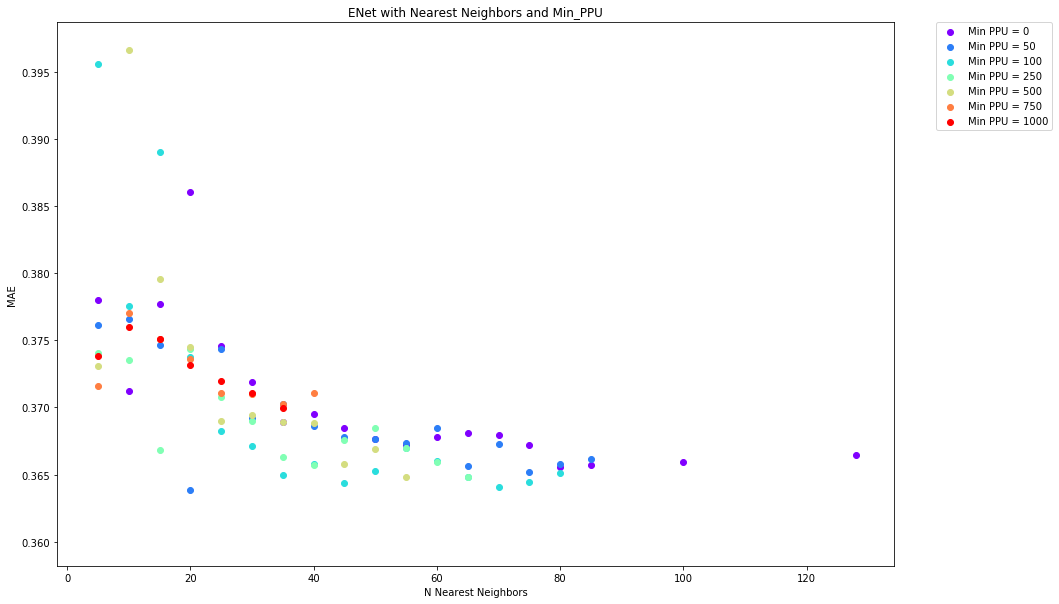



count vectorizer
FEATURES  ['ABV', 'IBU', 'global_rating', 'abbey', 'adambier', 'alcoholic', 'ale', 'altbier', 'amber', 'american']


TARGET  user_rating


User of Reference for Cosine Sim = tsharp93


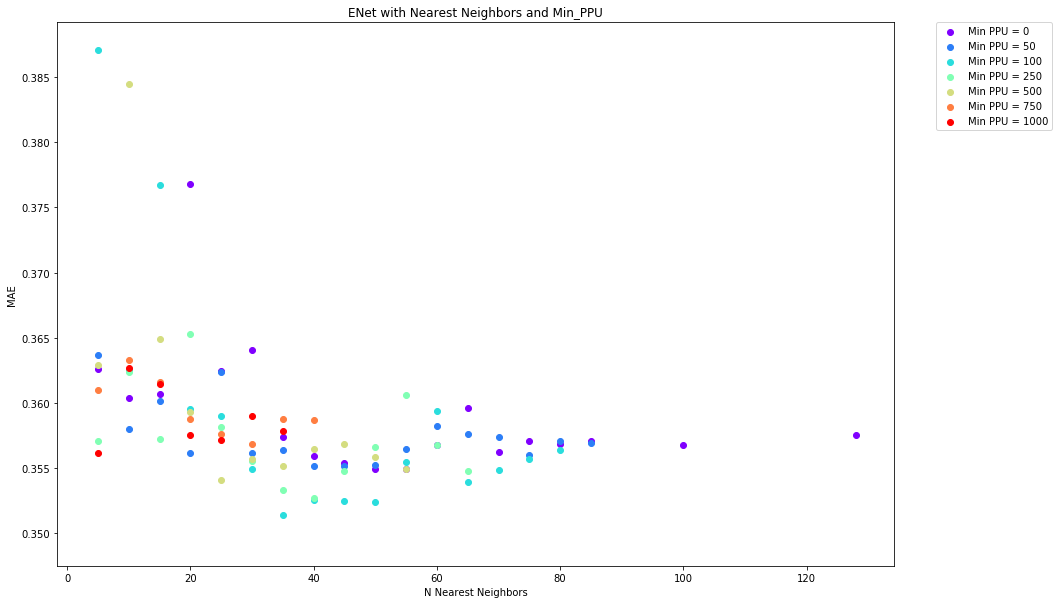



tfidf vectorizer
FEATURES  ['ABV', 'IBU', 'global_rating', 'abbey', 'adambier', 'alcoholic', 'ale', 'altbier', 'amber', 'american']


TARGET  user_rating


User of Reference for Cosine Sim = tsharp93


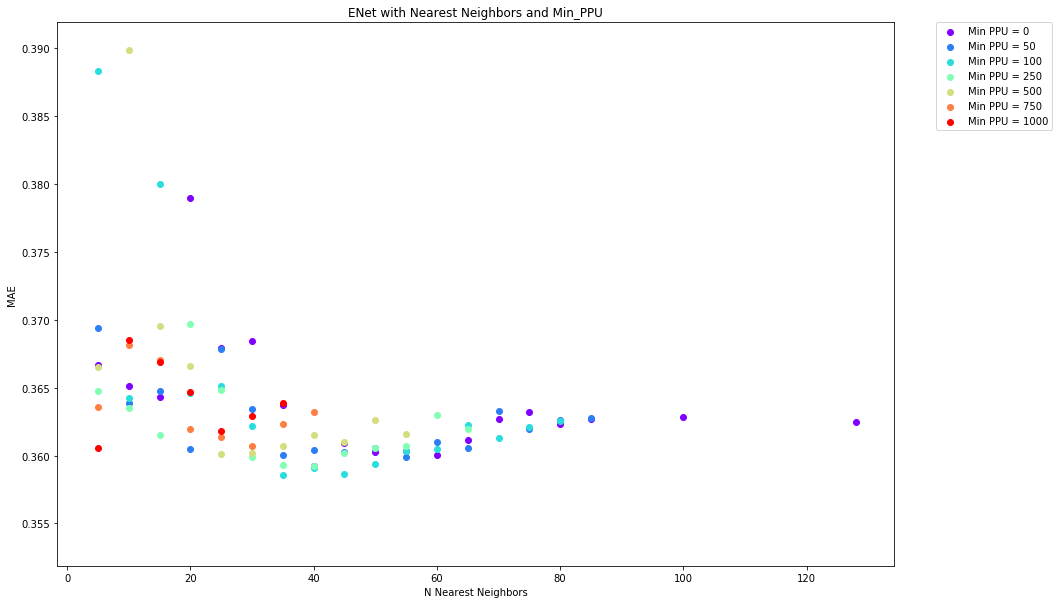

In [55]:
drop_cols = ['brewery']

print("\n")
print("Hybrid")
print("categorical encoding")
hybrid_df = cat_encoding(df, 'beer_description', drop_cols)
hybrid(hybrid_df, user_of_interest, 'user_rating')

print("\n")
print("count vectorizer")
hybrid_df = count_vectorizer(df, 'beer_description', drop_cols)
hybrid(hybrid_df, user_of_interest, 'user_rating')

print("\n")
print("tfidf vectorizer")
hybrid_df= tfidf_vectorizer(df,'beer_description', drop_cols)
hybrid(hybrid_df, user_of_interest, 'user_rating')